# **A) Data Gathering**

Downloading Audio Files

In [ ]:
import os
import urllib.request
import zipfile

# Defining the data folder
data_folder = os.path.join(os.path.expanduser("~"), "Emo-DB")

# Downloading
if not os.path.exists(data_folder):
    url = "http://emodb.bilderbar.info/download/download.zip"
    zip_path = os.path.join(data_folder, "download.zip")
    os.makedirs(data_folder, exist_ok=True)
    print("Downloading Emo-DB (40.5 MB) ...")
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import librosa
import numpy as np
import os

# Defining paths
wav_folder = os.path.join(data_folder, "wav")
save_folder = "/content/drive/My Drive/AI_HW#4"

Forming the data frame

In [ ]:
# Mapping from label letter to numerical value
label_map = {'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6}

# Creating the DataFrame
data = []
for file_name in os.listdir(wav_folder):
    if file_name.endswith(".wav"):
        label = label_map[file_name[-6].upper()]
        data.append([os.path.join(wav_folder, file_name), label])

df = pd.DataFrame(data, columns=["file_path", "label"])

# Saving the DataFrame
df.to_csv(os.path.join(save_folder, "audio_labels.csv"), index=False)

print(f"Number of audio files: {len(df)}")

Number of audio files: 535


In [ ]:
df.head()

,file_path,label
0,/root/Emo-DB/wav/15b10Nc.wav,6
1,/root/Emo-DB/wav/11a02Ld.wav,1
2,/root/Emo-DB/wav/08a07La.wav,1
3,/root/Emo-DB/wav/11b03Fc.wav,4
4,/root/Emo-DB/wav/14a02Ab.wav,3


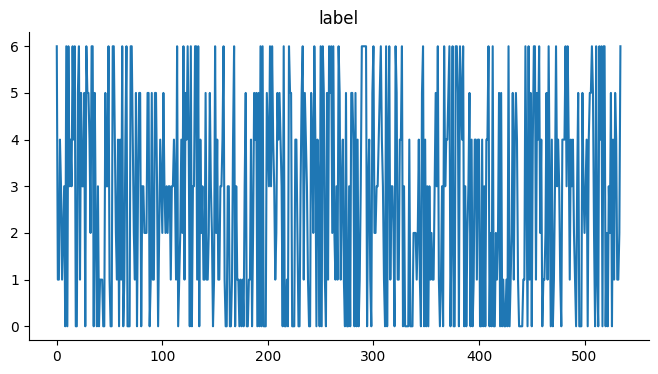

In [ ]:
# @title label

from matplotlib import pyplot as plt
df['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

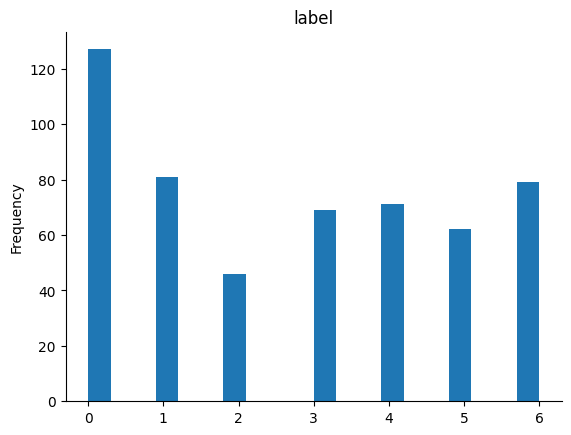

In [ ]:
# @title label

from matplotlib import pyplot as plt
df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

Data Augmentation (pitch shifting and time stretching)

In [ ]:
import random
import librosa
import numpy as np
import os
import soundfile as sf
import pandas as pd

# Function to apply pitch shifting
def pitch_shift_data(df):
    pitch_shifted_data = []
    for index, row in df.iterrows():
        file_path = row["file_path"]
        label = row["label"]
        y, sr = librosa.load(file_path, sr=None)

        # Pitch Shift
        for _ in range(3):
            pitch_factor = random.uniform(-3, 3)
            y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_factor)
            pitch_shifted_data.append([y_pitch, sr, label])

    return pitch_shifted_data

# Function to apply time stretching
def time_stretch_data(df):
    time_stretched_data = []
    for index, row in df.iterrows():
        file_path = row["file_path"]
        label = row["label"]
        y, sr = librosa.load(file_path, sr=None)

        # Time Stretch
        for _ in range(3):
            stretch_factor = random.uniform(0.8, 1.2)
            y_stretch = librosa.effects.time_stretch(y, rate=stretch_factor)
            time_stretched_data.append([y_stretch, sr, label])

    return time_stretched_data

# Function to save augmented data
def save_augmented_data(augmented_data, folder):
    os.makedirs(folder, exist_ok=True)
    file_paths = []

    for i, (y, sr, label) in enumerate(augmented_data):
        file_name = f"aug_{i}.wav"
        file_path = os.path.join(folder, file_name)
        sf.write(file_path, y, sr)
        file_paths.append([file_path, label])

    return file_paths

# Augmenting with pitch shift
pitch_shifted_data = pitch_shift_data(df)

# Augmenting with time stretch
time_stretched_data = time_stretch_data(df)

# Saving pitch-shifted data
pitch_shifted_folder = os.path.join(save_folder, "pitch_shifted")
pitch_shifted_file_paths = save_augmented_data(pitch_shifted_data,
                                               pitch_shifted_folder)

# Saving time-stretched data
time_stretched_folder = os.path.join(save_folder, "time_stretched")
time_stretched_file_paths = save_augmented_data(time_stretched_data,
                                                time_stretched_folder)

# Converting augmented file paths and labels to DataFrame
pitch_shifted_df = pd.DataFrame(pitch_shifted_file_paths,
                                columns=["file_path", "label"])
time_stretched_df = pd.DataFrame(time_stretched_file_paths,
                                 columns=["file_path", "label"])

# Concatenating original, pitch-shifted, and time-stretched DataFrames
augmented_df = pd.concat([df, pitch_shifted_df, time_stretched_df],
                         ignore_index=True)

# Saving the updated DataFrame
augmented_df.to_csv(os.path.join(save_folder, "audio_labels_augmented.csv"),
                    index=False)

print(augmented_df.head())

# Print the total number of audio files
print(f"Total number of audio files: {len(augmented_df)}")


Data augmentation complete and DataFrame saved.
                      file_path  label
0  /root/Emo-DB/wav/15b10Nc.wav      6
1  /root/Emo-DB/wav/11a02Ld.wav      1
2  /root/Emo-DB/wav/08a07La.wav      1
3  /root/Emo-DB/wav/11b03Fc.wav      4
4  /root/Emo-DB/wav/14a02Ab.wav      3
Total number of audio files: 3745


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting data sets:
train_df, temp_df = train_test_split(augmented_df, test_size=0.3, random_state=42)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Length of Train Set: {len(train_df)}")
print(f"Length of Validation Set: {len(val_df)}")
print(f"Length of Test Set: {len(test_df)}")

# Saving the data sets
train_df.to_csv(os.path.join(save_folder, "train.csv"), index=False)
test_df.to_csv(os.path.join(save_folder, "test.csv"), index=False)
val_df.to_csv(os.path.join(save_folder, "val.csv"), index=False)


Length of Train Set: 2621
Length of Validation Set: 562
Length of Test Set: 562


# **B) Data preparation**

Importing noiserdeuce Moldule

In [ ]:
!pip install noisereduce

Processing Audio Files (converting analog to digital, noise reduction, DFT, MFCCs, and Normalizing)

In [ ]:
import noisereduce as nr

def process_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Convert audio to digital with 20ms spans
    y_resampled = librosa.resample(y, orig_sr=sr, target_sr=16000)

    # Reduce noise
    y_denoised = nr.reduce_noise(y=y_resampled, sr=16000)

    # DFT
    y_dft = np.fft.fft(y_denoised)

    # Extracting MFCC features
    mfccs = librosa.feature.mfcc(y=y_denoised, sr=16000, n_mfcc=12)
    energy = np.sum(y_denoised**2) / len(y_denoised)

    features = np.vstack([mfccs, np.full((1, mfccs.shape[1]), energy)])

    # Normalizing the features
    features = librosa.util.normalize(features, axis=1)

    # Leveling Lengths to 150
    if features.shape[1] < 150:
        features = np.pad(features, ((0, 0), (0, 150 - features.shape[1])),
                          mode='constant')
    else:
        features = features[:, :150]

    return features

def create_feature_matrix(df):
    feature_list = []
    for index, row in df.iterrows():
        features = process_audio(row["file_path"])
        feature_list.append(features)

    return np.array(feature_list)

train_features = create_feature_matrix(train_df)
test_features = create_feature_matrix(test_df)
val_features = create_feature_matrix(val_df)

# Save the features
np.save(os.path.join(save_folder, "train_features.npy"), train_features)
np.save(os.path.join(save_folder, "test_features.npy"), test_features)
np.save(os.path.join(save_folder, "val_features.npy"), val_features)

# Save the labels
np.save(os.path.join(save_folder, "train_labels.npy"), train_df["label"].values)
np.save(os.path.join(save_folder, "test_labels.npy"), test_df["label"].values)
np.save(os.path.join(save_folder, "val_labels.npy"), val_df["label"].values)

Feature extraction and saving complete.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [ ]:
# Load the features and labels
train_features = np.load(os.path.join(save_folder, "train_features.npy"))
test_features = np.load(os.path.join(save_folder, "test_features.npy"))
val_features = np.load(os.path.join(save_folder, "val_features.npy"))

train_labels = np.load(os.path.join(save_folder, "train_labels.npy"))
test_labels = np.load(os.path.join(save_folder, "test_labels.npy"))
val_labels = np.load(os.path.join(save_folder, "val_labels.npy"))

Reshaping the data sets

In [ ]:
# Reshape the data for CNN
train_features = train_features[..., np.newaxis]
test_features = test_features[..., np.newaxis]
val_features = val_features[..., np.newaxis]

num_classes = len(np.unique(train_labels))
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)

Creating CNN model

In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = train_features.shape[1:]
model = create_cnn_model(input_shape, num_classes)

Compiling Models

In [ ]:
# Function to compile and train the model
def compile_and_train(model, loss_function, train_features, train_labels, val_features, val_labels, epochs=50):
    model.compile(optimizer=Adam(), loss=loss_function, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(train_features, train_labels,
                        validation_data=(val_features, val_labels),
                        epochs=epochs,
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=1)
    return history

# Train with loss function 'categorical_crossentropy'
model_1 = create_cnn_model(input_shape, num_classes)
history_1 = compile_and_train(model_1, 'categorical_crossentropy', train_features, train_labels, val_features, val_labels)

# Train with loss function 'mean_squared_error'
model_2 = create_cnn_model(input_shape, num_classes)
history_2 = compile_and_train(model_2, 'mean_squared_error', train_features, train_labels, val_features, val_labels)

Epoch 1/50
82/82 [==============================] - 6s 59ms/step - loss: 1.5598 - accuracy: 0.3945 - val_loss: 1.1775 - val_accuracy: 0.5676
Epoch 2/50
82/82 [==============================] - 6s 77ms/step - loss: 1.1820 - accuracy: 0.5395 - val_loss: 1.0038 - val_accuracy: 0.6388
Epoch 3/50
82/82 [==============================] - 6s 67ms/step - loss: 1.0076 - accuracy: 0.6166 - val_loss: 0.9053 - val_accuracy: 0.6459
Epoch 4/50
82/82 [==============================] - 5s 58ms/step - loss: 0.8510 - accuracy: 0.6768 - val_loss: 0.7873 - val_accuracy: 0.7278
Epoch 5/50
82/82 [==============================] - 7s 86ms/step - loss: 0.7257 - accuracy: 0.7272 - val_loss: 0.6853 - val_accuracy: 0.7420
Epoch 6/50
82/82 [==============================] - 5s 58ms/step - loss: 0.6194 - accuracy: 0.7711 - val_loss: 0.6410 - val_accuracy: 0.7687
Epoch 7/50
82/82 [==============================] - 5s 59ms/step - loss: 0.5523 - accuracy: 0.7966 - val_loss: 0.5289 - val_accuracy: 0.8114
Epoch 8/50
82

In [ ]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    return accuracy

# Evaluate both models
test_accuracy_1 = evaluate_model(model_1, test_features, test_labels)
test_accuracy_2 = evaluate_model(model_2, test_features, test_labels)

print(f"Test accuracy with categorical_crossentropy: {test_accuracy_1:.4f}")
print(f"Test accuracy with mean_squared_error: {test_accuracy_2:.4f}")

18/18 [==============================] - 1s 43ms/step
Test accuracy with categorical_crossentropy: 0.9057
Test accuracy with mean_squared_error: 0.9093


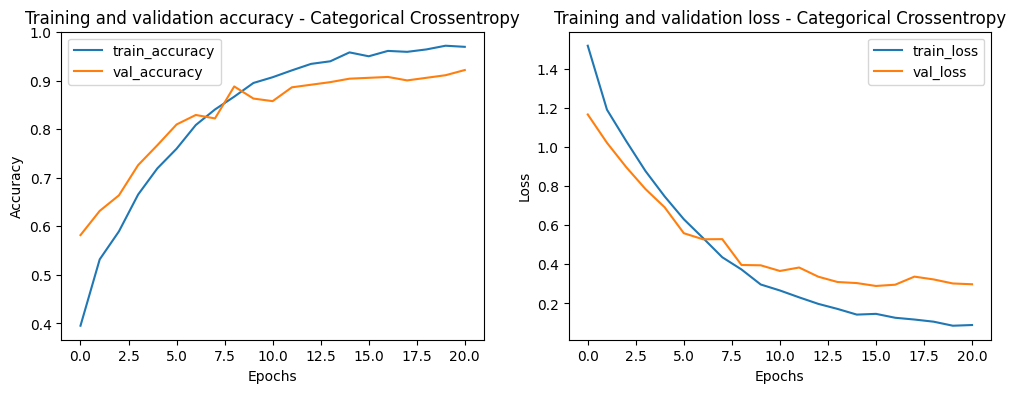

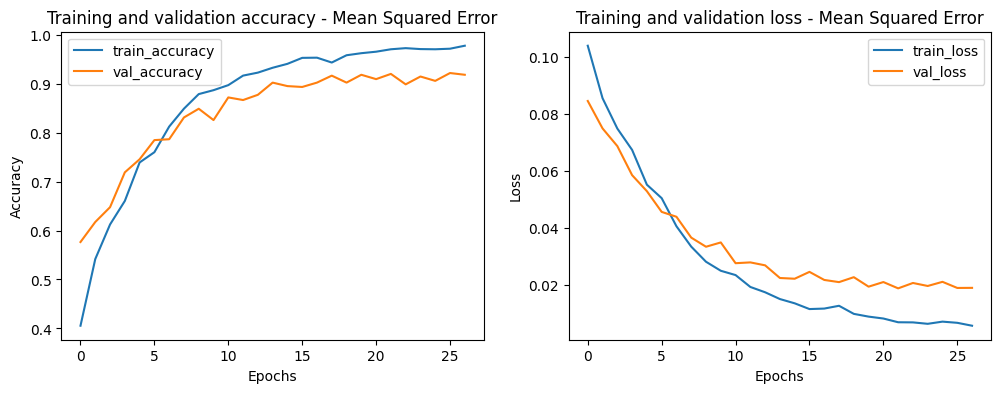

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history_1, 'Categorical Crossentropy')
plot_history(history_2, 'Mean Squared Error')


18/18 [==============================] - 1s 43ms/step
Test accuracy with categorical_crossentropy: 0.9057
Test accuracy with mean_squared_error: 0.9093


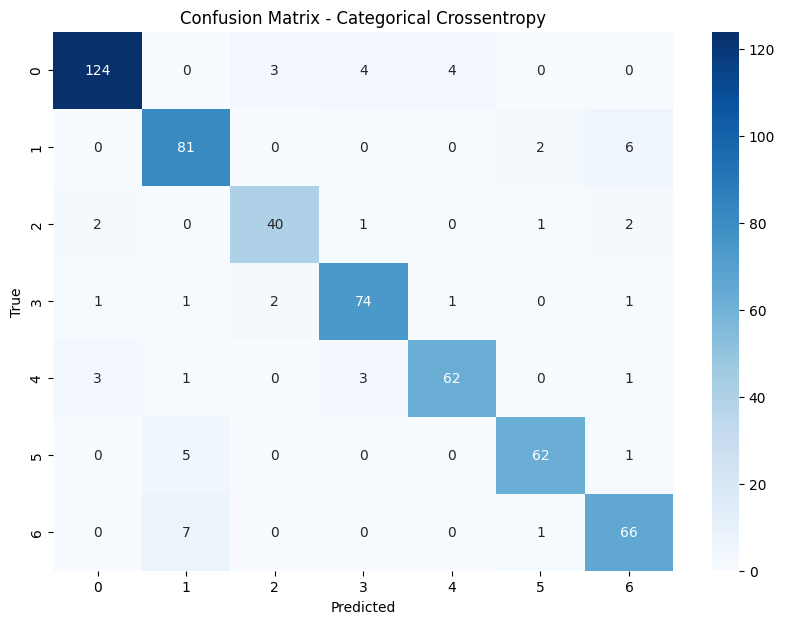

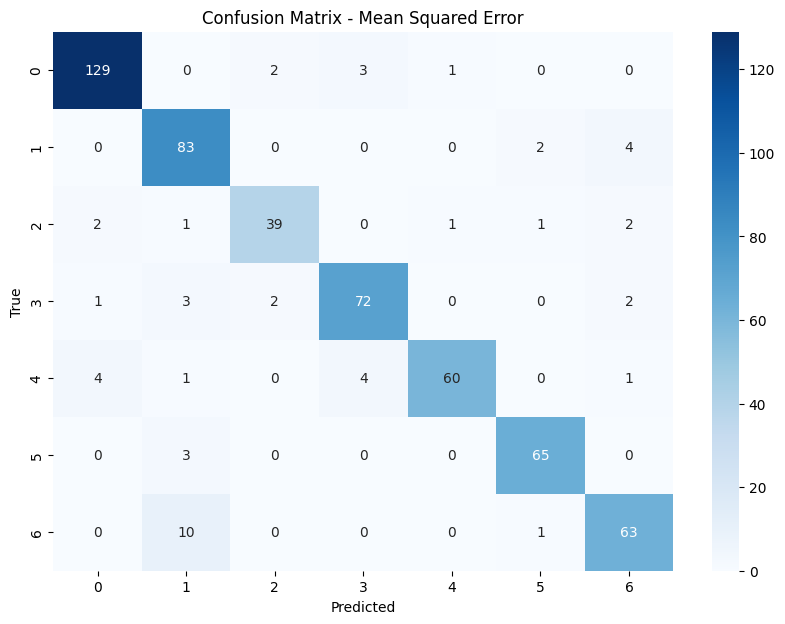

In [ ]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    return accuracy, true_classes, predicted_classes

# Evaluate both models
test_accuracy_1, true_classes_1, predicted_classes_1 = evaluate_model(model_1, test_features, test_labels)
test_accuracy_2, true_classes_2, predicted_classes_2 = evaluate_model(model_2, test_features, test_labels)

print(f"Test accuracy with categorical_crossentropy: {test_accuracy_1:.4f}")
print(f"Test accuracy with mean_squared_error: {test_accuracy_2:.4f}")

# Confusion Matrix
def plot_confusion_matrix(true_classes, predicted_classes, title):
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(true_classes_1, predicted_classes_1, 'Categorical Crossentropy')
plot_confusion_matrix(true_classes_2, predicted_classes_2, 'Mean Squared Error')


In [ ]:
from tensorflow.keras.layers import LSTM, TimeDistributed, Reshape, BatchNormalization
import seaborn as sns

# Load the data
train_features = np.load(os.path.join(save_folder, "train_features.npy"))
test_features = np.load(os.path.join(save_folder, "test_features.npy"))
val_features = np.load(os.path.join(save_folder, "val_features.npy"))

train_labels = np.load(os.path.join(save_folder, "train_labels.npy"))
test_labels = np.load(os.path.join(save_folder, "test_labels.npy"))
val_labels = np.load(os.path.join(save_folder, "val_labels.npy"))

# Reshape the data for CNN-LSTM
train_features = train_features[..., np.newaxis]
test_features = test_features[..., np.newaxis]
val_features = val_features[..., np.newaxis]

# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)

def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), activation='relu',
                                     padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 1),
                                           padding='same')))
    model.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3),
                                     activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 1), padding='same')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Adjust input shape for TimeDistributed layer
input_shape = (train_features.shape[1], train_features.shape[2],
               train_features.shape[3], 1)
model = create_cnn_lstm_model(input_shape, num_classes)


In [ ]:
# Function to compile and train the model
def compile_and_train(model, loss_function, train_features, train_labels,
                      val_features, val_labels, epochs=50):
    model.compile(optimizer=Adam(), loss=loss_function, metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                                   restore_best_weights=True)
    history = model.fit(train_features, train_labels,
                        validation_data=(val_features, val_labels),
                        epochs=epochs,
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=1)
    return history

# Train with loss function 'categorical_crossentropy'
model_1 = create_cnn_lstm_model(input_shape, num_classes)
history_1 = compile_and_train(model_1, 'categorical_crossentropy',
                          train_features, train_labels, val_features, val_labels)

# Train with loss function 'mean_squared_error'
model_2 = create_cnn_lstm_model(input_shape, num_classes)
history_2 = compile_and_train(model_2, 'mean_squared_error',
                          train_features, train_labels, val_features, val_labels)


Epoch 1/50
82/82 [==============================] - 82s 829ms/step - loss: 1.8346 - accuracy: 0.2587 - val_loss: 1.5293 - val_accuracy: 0.4591
Epoch 2/50
82/82 [==============================] - 25s 302ms/step - loss: 1.4528 - accuracy: 0.4071 - val_loss: 1.2498 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 27s 327ms/step - loss: 1.3171 - accuracy: 0.4613 - val_loss: 1.2409 - val_accuracy: 0.5018
Epoch 4/50
82/82 [==============================] - 27s 335ms/step - loss: 1.2496 - accuracy: 0.4857 - val_loss: 1.2163 - val_accuracy: 0.5267
Epoch 5/50
82/82 [==============================] - 27s 326ms/step - loss: 1.1661 - accuracy: 0.5151 - val_loss: 1.0995 - val_accuracy: 0.5320
Epoch 6/50
82/82 [==============================] - 29s 349ms/step - loss: 1.1233 - accuracy: 0.5479 - val_loss: 1.0186 - val_accuracy: 0.5961
Epoch 7/50
82/82 [==============================] - 29s 350ms/step - loss: 1.0618 - accuracy: 0.5933 - val_loss: 1.0806 - val_accuracy: 0.5516

18/18 [==============================] - 2s 80ms/step
Test accuracy with categorical_crossentropy: 0.8399
Test accuracy with mean_squared_error: 0.8025


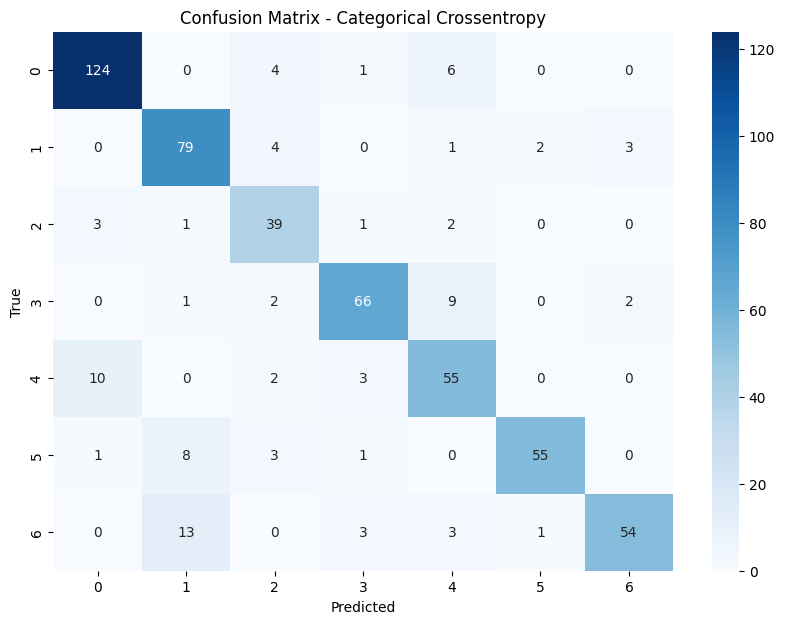

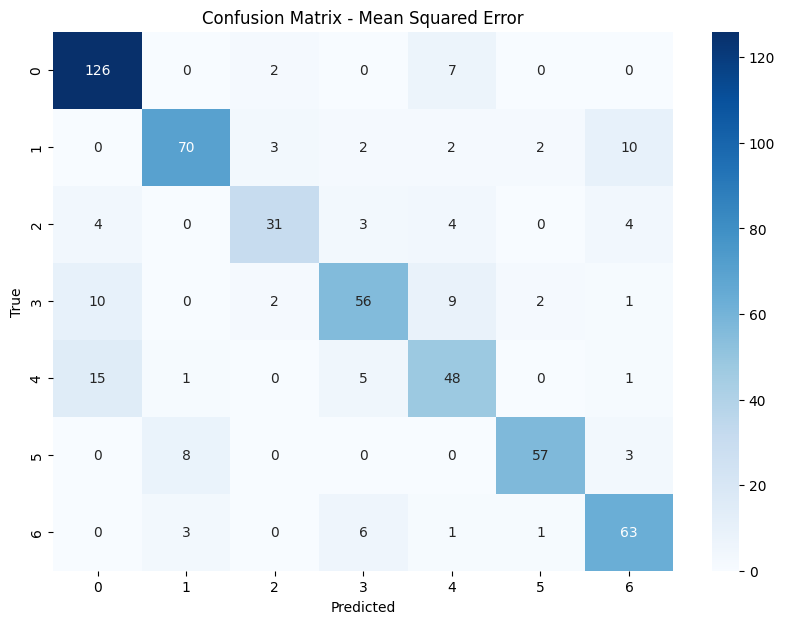

In [ ]:
def evaluate_model(model, test_features, test_labels):
    predictions = model.predict(test_features)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels, axis=1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    return accuracy, true_classes, predicted_classes

# Evaluate both models
test_accuracy_1, true_classes_1, predicted_classes_1 = evaluate_model(model_1,
                                                      test_features, test_labels)
test_accuracy_2, true_classes_2, predicted_classes_2 = evaluate_model(model_2,
                                                      test_features, test_labels)

print(f"Test accuracy with categorical_crossentropy: {test_accuracy_1:.4f}")
print(f"Test accuracy with mean_squared_error: {test_accuracy_2:.4f}")

# Confusion Matrix
def plot_confusion_matrix(true_classes, predicted_classes, title):
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(true_classes_1, predicted_classes_1,
                      'Categorical Crossentropy')
plot_confusion_matrix(true_classes_2, predicted_classes_2, 'Mean Squared Error')
